# Homework 6 - Regularization of Neural Networks using AD.

***
**Name**: __Poorwa Hirve__
***

## Goal

In this assignment you will be implementing and inspecting the effect of the following regularization techniques on neural networks.  
1. L1 Regularization
2. L2 Regularization
3. Random Dropout

This assigment is due for submission on **Tuesday - 03/12/2019**.

**NOTE:** Before continuing, I suggest you go through the sources: `optimizer.py` and `mlpnetwork.py` to get to know the convienence methods for loading and saving trained models. Average runtime of this notebook ("Experiment" specifically) is 2-2.5 hours. manage your time accordingly.   

In [1]:
# import libs
from tensor import Tensor
from optimizer import Optimizer
from mlpnetwork import MLPNetwork
import numpy as np
import copy # you'll need copy for initializing network layers to the same state.
from sklearn.utils import shuffle
from collections import OrderedDict
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
initial = 'InitialWeights'
initial_weights_dir = './data/initial_weights/' + initial
saved_model_dir = './data/saved_models/'

### Implementation

#### Randomly initlalized network weights

In [3]:
class MLP(MLPNetwork):
    def __init__(self, l1_weights, l2_weights):
        super(MLP, self).__init__()
        # Initialize a 1 hidden layer neural network here.
        self.l1 = Tensor(copy.deepcopy(l1_weights))
        self.l2 = Tensor(copy.deepcopy(l2_weights))
        
    def forward(self, X):
        """
            Implement the forward pass here.
            Available activations:
            1. ReLU
            2. Sigmoid
            See tensor.py for implementation details.
            
            return:
            (Tensor) final layer activations/predictions.
        """

        a1 = X.dot(self.l1).relu()
        a2 = a1.dot(self.l2).sigmoid()
        
        return a2

    def update(self, opt):
        opt.step(self)

    def get_L1_norm(self):
        """
            Implement the L1 norm of the layer weights.
            
            Returns:
            (Tensor) L1 norm of the layer weights.
            Make sure you use the AD framework so that the
            norm computation is recorded in the computational
            graph.
            
            
            Check wiki for the definition of L1 norm.
        """
        return (self.l1.abs()).sum() + (self.l2.abs()).sum()
                
    def get_L2_norm(self):
        """
            Implement the L2 norm of the layer weights.
            
            Returns:
            (Tensor) L2 norm of the layer weights.
            Make sure you use the AD framework so that the
            norm computation is recorded in the computational
            graph.
            
            Check wiki for the definition of L2 norm.
        """
        return (self.l1.pow(2)).sum() + (self.l2.pow(2)).sum()

#### Random Dropout

You are encouraged to check out the papers [here](https://arxiv.org/abs/1207.0580) and [here](http://jmlr.org/papers/v15/srivastava14a.html) for additional references for dropout.

In [4]:
class MLPDropout(MLPNetwork):
    def __init__(self, l1_weights, l2_weights, drop_out):
        super(MLPDropout, self).__init__()
        # Initialize a 1 layer hidden neural network here.
        # Drop out the hidden layer
        self.training = True # Training flag will be needed for Dropout 
        self.dropout_p = drop_out # Hyperparameter!
        self.l1 = Tensor(copy.deepcopy(l1_weights))
        self.l2 = Tensor(copy.deepcopy(l2_weights))
        
    def forward(self, X):
        """
            Implement the forward pass with and without
            dropout here. Make sure that your DropOut layer is
            recorded in the computational graph.
            
            Available activations:
            1. ReLU
            2. Sigmoid
            See tensor.py for implementation details.
            
            return:
            (Tensor) final layer activations/predictions.
        """
        
        a1 = X.dot(self.l1).relu()
        
        if self.training:
            self.mask = Tensor(np.random.binomial(size=a1.value.shape, n=1, p=self.dropout_p) / self.dropout_p)
            a1 = a1 * self.mask
            self.act = a1
            
        a2 = a1.dot(self.l2).sigmoid()
        
        return a2

    def update(self, opt):
        opt.step(self)

    def get_L1_norm(self):
        """
            Same as MLP
        """
        return (self.l1.abs()).sum() + (self.l2.abs()).sum()
        
    def get_L2_norm(self):
        """
            Same as MLP
        """
        return (self.l1.pow(2)).sum() + (self.l2.pow(2)).sum()

#### Dataset

In [5]:
X_train, y_train = np.load('./data/X_train.npy'), np.load('./data/y_train.npy')
X_test, y_test = np.load('./data/X_test.npy'), np.load('./data/y_test.npy')

#### Train and Test loop

In [6]:
def step(y):
    for i in range(y.value.shape[0]):
        if y.value[i] >= 0.5:
            y.value[i] = 1
        else:
            y.value[i] = 0
    return y

def train(model, X_train, y_train, epochs, batch_size, opt, reg_flag, reg_weight = None):
    """
        Train loop.
        
        params:
        model (MLP): 
            An MLP model to be trained. 
            MLP model must inherit the MLPNetwork module.
        X_train (np.ndarray): 
            Training set. 600 features per sample.
        y_train (np.ndarray):
            Training lables. 0 or 1.
        epochs (int): Epochs
        batch_size (int): Batch size
        opt (Optimizer): 
            Only sgd optimizer has been released for obvious reasons.
        reg_flag (int):
            An integer flag for your convienence. Use it to switch between
            different L1, L2 and NO regularization penalties.
        reg_weight ( array of floats ):
            Weight(s) for regularization penalties. 
            You can get creative with this as well. 
            It is an array of floats. Take the hint.
        
        return:
        Implementation choice.
    """
    mse_list = []
    batches = X_train.shape[0] / batch_size
    n_hid = model.l1.value.shape[1]
    
    for epoch in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        batch_error = []
        for j in range(0, X_train.shape[0], batch_size):
            X = Tensor(X_train[j:j+batch_size])
            y_actual = Tensor(y_train[j:j+batch_size])

            y_hat = model.forward(X)
            
            model.zero_grad(opt)
            
            error = ((y_hat - y_actual).pow(2)).mean()
            
            if reg_flag == 0:
                reg = Tensor(0)
            elif reg_flag == 1: 
                reg = Tensor(reg_weight[0]) * model.get_L1_norm()
                
            elif reg_flag == 2:
                reg = Tensor(reg_weight[1]) * model.get_L2_norm()
                
            error = error + reg
            batch_error.append(error.value)
            
            error.backward()
            
            if type(model) == MLPDropout:
                model.act.grad = model.act.grad * model.mask.value
            
            model.update(opt)
            
#         model.update_state_dict()
        
        mse_list.append(sum(batch_error) / batches)
    
    model.save_state(saved_model_dir + model.__class__.__name__+'_'+str(n_hid)+'_'+str(reg_flag)+'.pickle')
    return mse_list 

def test(X_test, y_test, model):
    """
        Implement this method such that it returns the
        accuracy as the number of correctly classified
        examples in the test set.
        
        params:
        model (MLP): 
            An MLP model to be trained. 
            MLP model must inherit the MLPNetwork module.
        X_test (np.ndarray): 
            Test set. 600 features per sample.
        y_test (np.ndarray):
            Training lables. 0 or 1.
        
    """
    accuracy = 0
    if type(model) == MLPDropout:
        model.training = False
        
    y_pred = step(model.forward(Tensor(X_test)))
    for i in range(y_test.shape[0]):
        if y_pred.value[i] == y_test[i]:
            accuracy += 1
        
    return (accuracy*100) / len(y_test)
    

> __Dropout Layer in MLP Dropout__
- Generate a mask:
    - size = hidden layer
    - values 1/0 using __keep_prob__ (probability of keeping the neuron, 1 means keep and 0 is drop)
    - multiply the hidden layer activation with the mask and scale by keep_prob 
- Apply dropout to the gradient of the hidden layer

### Experiment

Select a value `lambda_lx` - the regularization parameter for L1 and L2 regularizers, and a `keep_prob` for Random DropOut. Using these values, train the 4 networks (No regularization, L1, L2 and DropOut regularized models respectively) with different number of hidden neurons ranging from 100-1700 in steps of 200. Tabulate the test accuracy of each of the models with same weight initialization and number of neurons in the hidden layer. The resulting table will be a 8x4 matrix.   Summarize your results in a short 280 word report.

In [7]:
### Dropout Probability, Hyperparameters and Optimizer

keep_prob = 0.5
lambda_l1 = 1e-2
lambda_l2 = 1e-2
lambdas = [lambda_l1, lambda_l2]
alpha = 0.5
opt = Optimizer(update_rule='sgd', lr=alpha)

epochs = 200
batch_size = 50

In [8]:
n_in = 600
n_hids = [i for i in range(100, 1501, 200)]
n_out = 1

> __NOTE:__  
> Uncomment the lines in the cell below to get initial weights.

In [9]:
# for n_hid in n_hids:
#     l1_weights = np.random.randn(n_in, n_hid)
#     l2_weights = np.random.randn(n_hid, n_out)
#     nn = MLPNetwork()
#     nn._state['l1'] = l1_weights
#     nn._state['l2'] = l2_weights
#     nn.save_state(initial + '_' + str(n_hid) + '.pickle')

In [10]:
### Initialize ordered dictionaries in order for mse for each type of network to be stored during training

mse_MLP = OrderedDict()
mse_MLP[0] = OrderedDict()
mse_MLP[1] = OrderedDict()
mse_MLP[2] = OrderedDict()

mse_MLPDropout = OrderedDict()
mse_MLPDropout[0] = OrderedDict()
# mse_MLPDropout[1] = OrderedDict()
# mse_MLPDropout[2] = OrderedDict()

In [11]:
### Initialize ordered dictionaries in order for accuracies for each type of network to be stored during testing

accuracy_MLP = OrderedDict()
accuracy_MLP[0] = OrderedDict()
accuracy_MLP[1] = OrderedDict()
accuracy_MLP[2] = OrderedDict()

accuracy_MLPDropout = OrderedDict()
accuracy_MLPDropout[0] = OrderedDict()
# accuracy_MLPDropout[1] = OrderedDict()
# accuracy_MLPDropout[2] = OrderedDict()

In [12]:
"""
1. Load Initial Weights into MLP and MLPDropout Networks
2. Train and store MSE in dictionaries
3. Test and store accuracy in dictionaries
"""

for n_hid in n_hids:
    print ()
    nn = MLPNetwork()
    nn.load_state(initial_weights_dir + '_' + str(n_hid) + '.pickle')
    
    for i in range(3):
        
        l1_weights, l2_weights = nn._state['l1'], nn._state['l2']

        mlp = MLP(l1_weights, l2_weights)
        mse_MLP[i][n_hid] = train(mlp, X_train, y_train, epochs, batch_size, opt, i, lambdas)
        accuracy_MLP[i][n_hid] = test(X_test, y_test, mlp)
        print (i if i > 0 else None, n_hid, accuracy_MLP[i][n_hid])
        print ()
        
    l1_weights, l2_weights = nn._state['l1'], nn._state['l2']

    mlp_dropout = MLPDropout(l1_weights, l2_weights, keep_prob)
    mse_MLPDropout[0][n_hid] = train(mlp_dropout, X_train, y_train, epochs, batch_size, opt, 0, lambdas)
    accuracy_MLPDropout[0][n_hid] = test(X_test, y_test, mlp_dropout)
    print ('Dropout', n_hid, accuracy_MLPDropout[0][n_hid])    
    print ()


INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_100.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_100.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 100 79.2



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 100 91.0



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 100 87.2



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_300.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_300.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 100 82.8




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 300 80.0



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 300 90.3



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 300 88.0



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_500.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_500.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 300 80.5




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 500 82.1



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 500 90.3



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 500 88.5



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_700.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_700.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 500 80.1




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 700 82.1



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 700 90.1



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 700 88.0



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_900.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_900.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 700 79.1




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 900 50.8



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 900 90.4



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 900 88.5



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_1100.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_1100.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 900 67.9




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 1100 81.3



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 1100 90.2



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 1100 88.6



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_1300.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_1300.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 1100 79.5




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 1300 51.3



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 1300 89.5



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 1300 88.0



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act
INFO:MLPNetwork:Initializing model params from file: ./data/initial_weights/InitialWeights_1500.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/initial_weights/InitialWeights_1500.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']


Dropout 1300 69.5




INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


None 1500 79.8



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


1 1500 90.8



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2


2 1500 87.6



INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:act


Dropout 1500 76.9



In [13]:
# print (accuracy_MLP)

In [14]:
# print (accuracy_MLPDropout)

In [15]:
# print ("Accuracies")
# for n_hid in n_hids:
#     print ("********************************************")
#     print ("Hidden Neurons:", n_hid)
#     print ("********************************************")
#     print ()
#     for i in range(3):
#         print ("Regularization:", "None" if i == 0 else "L1" if i == 1 else "L2")
#         print ()
#         print ("MLP:", accuracy_MLP[i][n_hid])
#         print ()
#     print ("MLP Dropout:", accuracy_MLPDropout[0][n_hid])

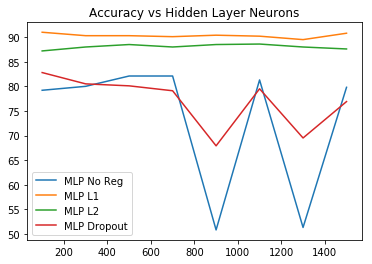

In [16]:
### Plots

plt.plot(n_hids, accuracy_MLP[0].values(), label='No Reg')
plt.plot(n_hids, accuracy_MLP[1].values(), label='L1')
plt.plot(n_hids, accuracy_MLP[2].values(), label='L2')
plt.plot(n_hids, accuracy_MLPDropout[0].values(), label='Dropout')
plt.title('Accuracy vs Hidden Layer Neurons')
plt.legend()
plt.show()

In [55]:
# accuracy_table_MLP = pd.DataFrame(accuracy_MLP)
# accuracy_table_MLP.columns = ['MLP No Reg','MLP L1','MLP L2']
# accuracy_table_MLPDropout = pd.DataFrame(accuracy_MLPDropout)
# accuracy_table_MLPDropout.columns = ['Dropout']
# accuracy_table_MLP.join(accuracy_table_MLPDropout)

In [56]:
### Helper function to get table to printout in Markdown

def get_rows():
    header = "|      | No Reg  |   L1    | L2      | Dropout |"
    header += "|------|---------|---------|---------|---------|"
    for n_hid in n_hids:
        space = 0
        if n_hid < 1000:
            space = 1
        row = "| "+str(n_hid)+ + space * ' ' + " | "
        for i in range(3):
            row += "%.2f" % round(accuracy_MLP[i][n_hid],2) + "   | "
        row += "%.2f" % round(accuracy_MLPDropout[0][n_hid],2) + "   | "
    return header + row

## Analysis

- I first estimated the hyperparameters to consider.
- I started by keeping these values very small and then increasing them depending on the results.
- Starting with 100 epochs, by keeping the learning rate (alpha) of $10^{-4}$ and lower, the accuracy would not go over $49-52\ \%$
    - Even with increasing epochs, there was not much improvement. Hence I increased the alpha values slowly.
    - Experimenting with the alpha values, I discovered that $0.1$ and $0.5$ worked well.
- Similarly, regularization parameters performed well in the order of $10^{-2}$

- I experimented with the keep_prob by first considering a high probability - $0.8$ and then going lower. I discovered that the best results I got were for $0.5$. While increasing dropout increases time to convergence, it decreases the time spent on each epoch.

- Decreasing the batch size also helped. Starting out with 100, I found out that keeping the batch size 50 was optimal taking into consideration the amount of time taken to run each epoch.

## Results of experiments and analysis

> __Experiment 1__:
- alpha = $0.1$
- L1: $\lambda$ = $0.001$
- L2: $\lambda$ = $0.01$
- epochs = $100$
- batch_size = $50$
- keep_prob = $0.8$
>
> Results:  
>
>|      | No Reg  |   L1    | L2      | Dropout |
|------|---------|---------|---------|---------|
| 100  | 54.00   | 60.40   | 87.90   | 65.70   | 
| 300  | 59.90   | 65.90   | 88.20   | 66.30   | 
| 500  | 64.40   | 69.20   | 88.40   | 68.70   | 
| 700  | 65.50   | 68.50   | 88.00   | 65.30   | 
| 900  | 59.80   | 68.10   | 87.80   | 67.30   | 
| 1100 | 63.10   | 71.50   | 87.70   | 65.50   | 
| 1300 | 68.60   | 69.90   | 88.20   | 65.70   | 
| 1500 | 64.20   | 69.60   | 88.50   | 63.70   |  
> As seen, the L1 $\lambda$ did not affect the accuracy as well as the L2 $\lambda$ which suggests that $10^{-3}$ is too less to affect the performance.

In [63]:
accuracy_100_no_reg = [54.0, 59.9, 64.4, 65.5, 59.8, 63.1, 68.6, 64.2]
accuracy_100_l1_reg = [60.4, 65.9, 69.2, 68.5, 68.1, 71.5, 69.9, 69.9]
accuracy_100_l2_reg = [87.9, 88.3, 88.4, 88.0, 87.8, 87.7, 88.2, 88.5]
accuracy_100_dropout = [65.7, 66.3, 68.7, 65.3, 67.3, 65.5, 65.7, 63.7]

> __Experiment 2__:
- alpha = $0.5$
- L1: $\lambda$ = $0.01$
- L2: $\lambda$ = $0.01$
- epochs = $200$
- batch_size = $50$
- keep_prob = $0.5$ 
>
> Results:
>
>|      | No Reg  |   L1    | L2      | Dropout |
|------|---------|---------|---------|---------|
| 100  | 79.20   | 91.00   | 87.20   | 82.80   | 
| 300  | 80.00   | 90.30   | 88.00   | 80.50   | 
| 500  | 82.10   | 90.30   | 88.50   | 80.10   | 
| 700  | 82.10   | 90.10   | 88.00   | 79.10   | 
| 900  | 50.80   | 90.40   | 88.50   | 67.90   | 
| 1100 | 81.30   | 90.20   | 88.60   | 79.50   | 
| 1300 | 51.30   | 89.50   | 88.00   | 69.50   | 
| 1500 | 79.80   | 90.80   | 87.60   | 76.90   |
>
> As seen from the results:
- No Regularization overfits when the model complexity increases to $\geq 900$ hidden neurons.
- L1 performs well suggesting that $0.01$ is a good value.
- L2 performs well suggesting that $0.01$ is a good value.
- Decreasing dropout to $0.5$ shows better performance than previous
    - Decreased time to run each epoch
    - Increased time for convergence

In [64]:
accuracy_200_no_reg = [79.2, 80.0, 82.1, 82.1, 50.8, 81.3, 51.3, 79.8]
accuracy_200_l1_reg = [91.0, 90.3, 90.3, 90.1, 90.4, 90.2, 89.5, 90.8]
accuracy_200_l2_reg = [87.2, 88.0, 88.5, 88.0, 88.5, 88.6, 88.0, 87.6]
accuracy_200_dropout = [82.8, 80.5, 80.1, 79.1, 67.9, 79.5, 69.5, 76.9]

> __Experiment 3__:
- alpha = $0.5$
- L1: $\lambda$ = $0.01$
- L2: $\lambda$ = $0.01$
- epochs = $300$
- batch_size = $50$
- keep_prob = $0.5$  
>
>
>- Results:  
>
>|      | No Reg  |   L1    | L2      | Dropout |
|------|---------|---------|---------|---------|
| 100  | 79.10   | 91.00   | 88.40   | 82.50   | 
| 300  | 82.10   | 90.10   | 86.70   | 82.10   | 
| 500  | 82.50   | 91.30   | 86.90   | 82.00   | 
| 700  | 50.80   | 89.90   | 87.70   | 80.90   | 
| 900  | 49.20   | 89.80   | 88.40   | 80.80   | 
| 1100 | 49.20   | 90.40   | 87.90   | 78.00   | 
| 1300 | 50.70   | 89.80   | 87.30   | 80.50   | 
| 1500 | 49.00   | 90.60   | 87.70   | 73.80   | 
> As seen from the results:
- No Regularization overfits when the model complexity increases to $\geq 900$ hidden neurons.
- L1 performs well suggesting that $0.01$ is a good value.
- L2 performs well suggesting that $0.01$ is a good value.
- Decreasing dropout to $0.5$ shows similar performance to previous

In [65]:
accuracy_300_no_reg = [79.1, 82.1, 82.5, 50.8, 49.2, 49.2, 50.7, 49.0]
accuracy_300_l1_reg = [91.0, 90.1, 91.3, 89.9, 89.8, 90.4, 89.8, 90.6]
accuracy_300_l2_reg = [88.4, 86.7, 86.9, 87.7, 88.4, 87.9, 87.3, 87.7]
accuracy_300_dropout = [82.5, 82.1, 82.0, 80.9, 80.8, 78.0, 80.5, 73.8]

## Plots

### Accuracies for each epoch for No Regularization

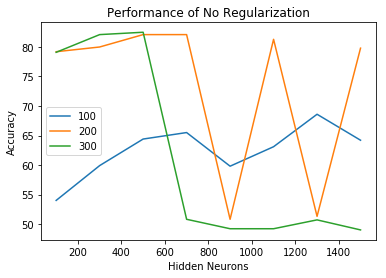

In [66]:
### Taking values from previously done experiments

no_reg_100 = [54.0, 59.9, 64.4, 65.5, 59.8, 63.1, 68.6, 64.2]
no_reg_200 = [79.2, 80.0, 82.1, 82.1, 50.8, 81.3, 51.3, 79.8]
no_reg_300 = [79.1, 82.1, 82.5, 50.8, 49.2, 49.2, 50.70, 49.0]

plt.plot(n_hids, no_reg_100, label='100')
plt.plot(n_hids, no_reg_200, label='200')
plt.plot(n_hids, no_reg_300, label='300')
plt.title('Performance of No Regularization')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- The above graph shows that $500$ hidden neurons shows good values before the model's accuracy starts to get affected.
- Now displaying the model's MSE values for $500$ hidden neurons.

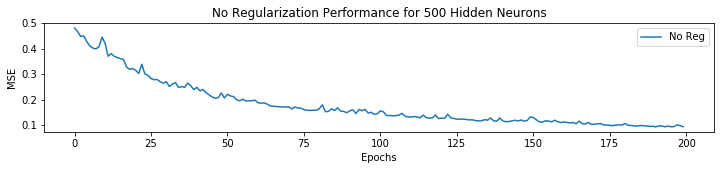

In [67]:
plt.figure(figsize=(12,2))
plt.plot(range(epochs), mse_MLP[0][500], label='No Reg')
plt.title('No Regularization Performance for 500 Hidden Neurons')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

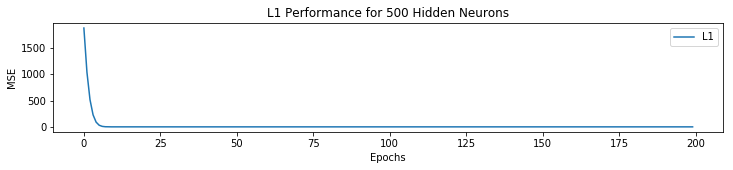

In [68]:
plt.figure(figsize=(12,2))
plt.plot(range(epochs), mse_MLP[1][500], label='L1')
plt.title('L1 Performance for 500 Hidden Neurons')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

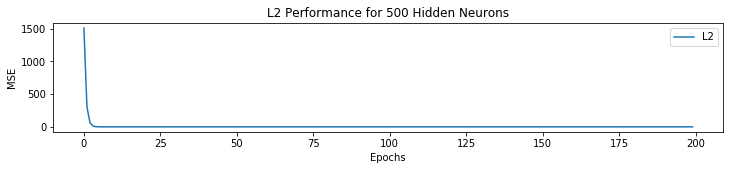

In [69]:
plt.figure(figsize=(12,2))
plt.plot(range(epochs), mse_MLP[2][500], label='L2')
plt.title('L2 Performance for 500 Hidden Neurons')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

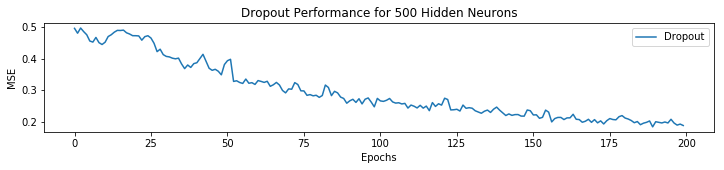

In [70]:
plt.figure(figsize=(12,2))
plt.plot(range(epochs), mse_MLPDropout[0][500], label='Dropout')
plt.title('Dropout Performance for 500 Hidden Neurons')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

- No Regularization, L1, L2 reach convergence before 200 epochs
- MSE for Dropout decreases significantly, but it has not reached convergence.

#### Now showing the performance of each network from each experiment

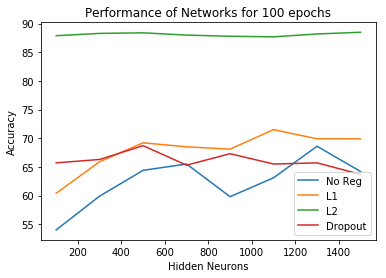

In [76]:
plt.plot(n_hids, accuracy_100_no_reg, label='No Reg')
plt.plot(n_hids, accuracy_100_l1_reg, label='L1')
plt.plot(n_hids, accuracy_100_l2_reg, label='L2')
plt.plot(n_hids, accuracy_100_dropout, label='Dropout')
plt.title('Performance of Networks for 100 epochs')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

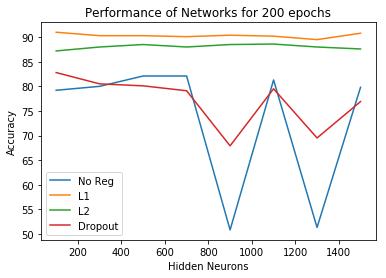

In [77]:
plt.plot(n_hids, accuracy_200_no_reg, label='No Reg')
plt.plot(n_hids, accuracy_200_l1_reg, label='L1')
plt.plot(n_hids, accuracy_200_l2_reg, label='L2')
plt.plot(n_hids, accuracy_200_dropout, label='Dropout')
plt.title('Performance of Networks for 200 epochs')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

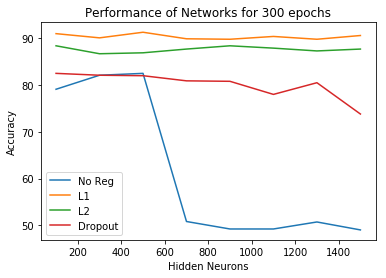

In [78]:
plt.plot(n_hids, accuracy_300_no_reg, label='No Reg')
plt.plot(n_hids, accuracy_300_l1_reg, label='L1')
plt.plot(n_hids, accuracy_300_l2_reg, label='L2')
plt.plot(n_hids, accuracy_300_dropout, label='Dropout')
plt.title('Performance of Networks for 300 epochs')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()